<a href="https://colab.research.google.com/github/razzkoirala/devops-camp-pipeline/blob/main/LabDocument/4_Artifact_Management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artifact Management
Updated 5/6/2022

## Overview
In this lab, students will learn how to "Dockerize" an application, retrieve artifacts from Nexus, and publish to Harbor. 

**Estimated time:** 60 min

Setup needed:
* Introduction to Docker Containers
*	Introduction to Artifacts Management
*	Introduction to Nexus/Harbor




## Learning Objectives

1.	Set up the project 

2.	Dockerize the GitHub repository

3.	Dockerize the Database

4.	Build new artifacts along with source code from VC

5.	Publish new build artifact to Harbor

6.	Verify artifact was added

# Instructions


## Set Up the Project

1. Create a Nexus PyPi proxy repository
  
  a. Navigate to the Nexus repository manager here: https://nexus.dev.afsmtddso.com/

  b. Sign in with your student credentials

<figure>
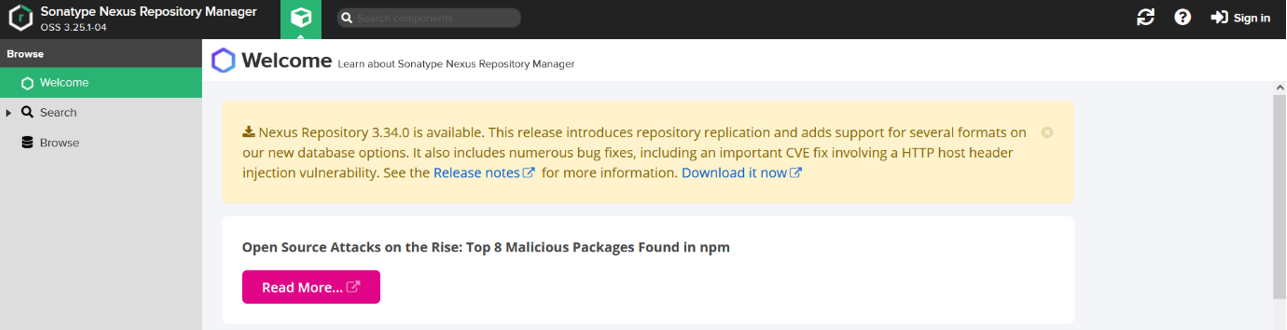
</figure>

<ul>

c. Click “Administration” (the settings gear icon) (1), then “Repositories” (2), then “Create repository” (3)

</ul>

<figure>
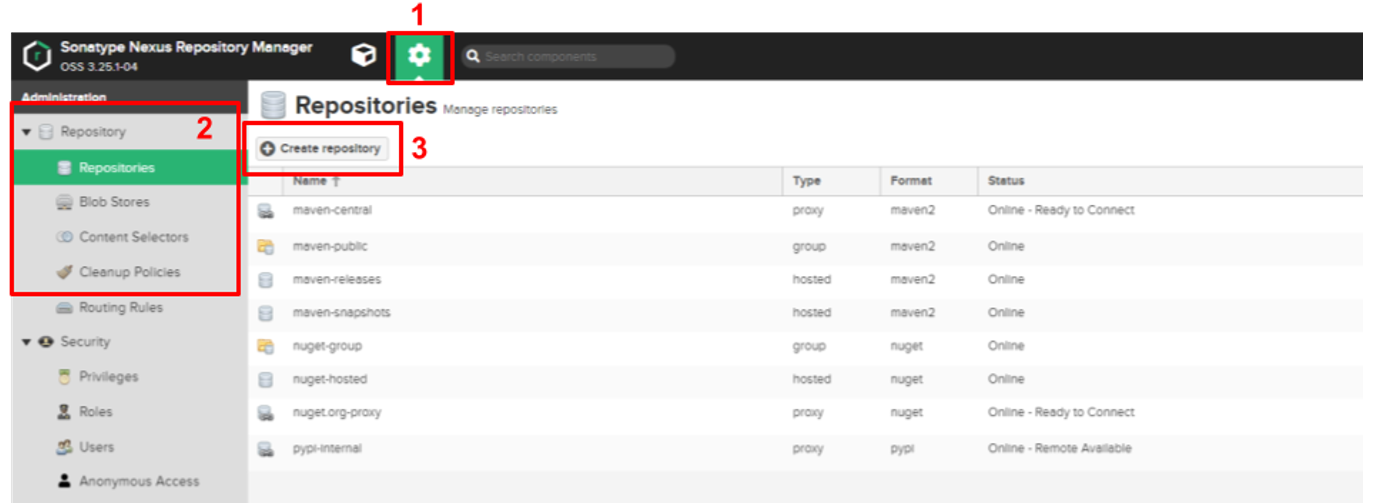
</figure>

<ul>

d. Scroll down in the Recipe list and select the “pypi (proxy)” type 

</ul>

<figure>
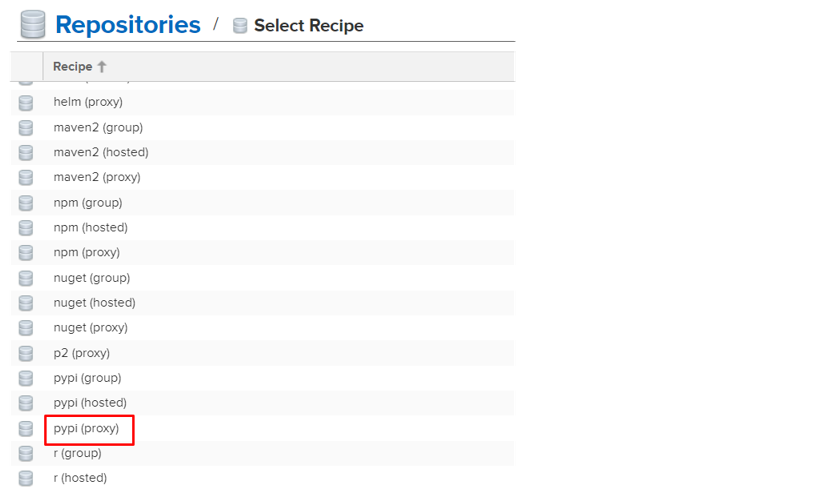
</figure>

<ul>

e. Name your repository `<first name initial + last name>-nexus-repo` for your repository and type `https://pypi.org/` into the “Remote storage” URL. You can leave all other settings as their default

</ul>

<figure>
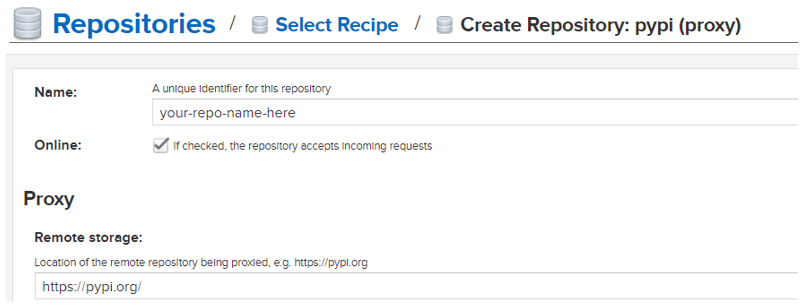
</figure>

<ul>

f. Scroll down and click “Create repository” to finish configuring your repository

</ul>

## Dockerize the Application

1.	In VSCode, within your lab environment container, create two folders in `devops-camp-pipeline` folder

2.	Name one folder `app` (for your application itself) and the other `db` (for the database).

3. Create a file in the `app` folder name it `Dockerfile`

4. Copy and paste in the following example to your `Dockerfile` and make sure to read the explanations underneath to understand why it works.

  >**Tip:** _Replace_ `<YOUR NEXUS REPO NAME>` with your Nexus repository name; it should be something like `<first initial + last name>-nexus-repo`



In [ ]:
FROM python:3.9
COPY / ./app/
WORKDIR app
RUN /bin/sh -c 'pip install --no-cache-dir --index-url https://nexus.dev.afsmtddso.com/repository/<YOUR NEXUS REPO NAME>/simple -r requirements.txt'
ENTRYPOINT ["python"]
CMD ["server.py"]

<ul>

> **Explanation of code:** 
>
> The first line of your Dockerfile specifies that your container is based on the Python Docker image, which can be pulled using the line `FROM python:3.9`
>
> We can copy the directory to its equivalent location in your Docker container using `COPY / ./app/`
>
> The `WORKDIR` instruction points your working directory to the `app` folder.
>
> The `RUN` instruction executes the `pip install` command to install the dependencies listed in `requirements.txt` through the Nexus repository.
>
> The `ENTRYPOINT` and `CMD` instructions tells the container to run the command `python server.py` at startup.

> **Tip:** Make sure to include `/simple` at the end of your Nexus repo URL.

</ul>


5. Save the changes to your `Dockerfile`

## Dockerize the Database

1.	Create another `Dockerfile` in the `db` folder, this time to configure your database Docker container

2.	In your Dockerfile, pull the postgres image using `FROM`, then copy your `database.sql` file to `/docker-entrypoint-initdb.d/` to set up the database:

In [ ]:
FROM postgres:9.6
COPY database/database.sql /docker-entrypoint-initdb.d/

3. Save the changes to your `Dockerfile`

4. In the VSCode terminal, make sure you're in your `devops-camp-pipeline` folder 

5. Add your files, commit, and push to your GitHub repository:

  a.	`git add .`

  b.	`git commit -m "committing dockerfiles"`

  c.	`git push`

<figure>
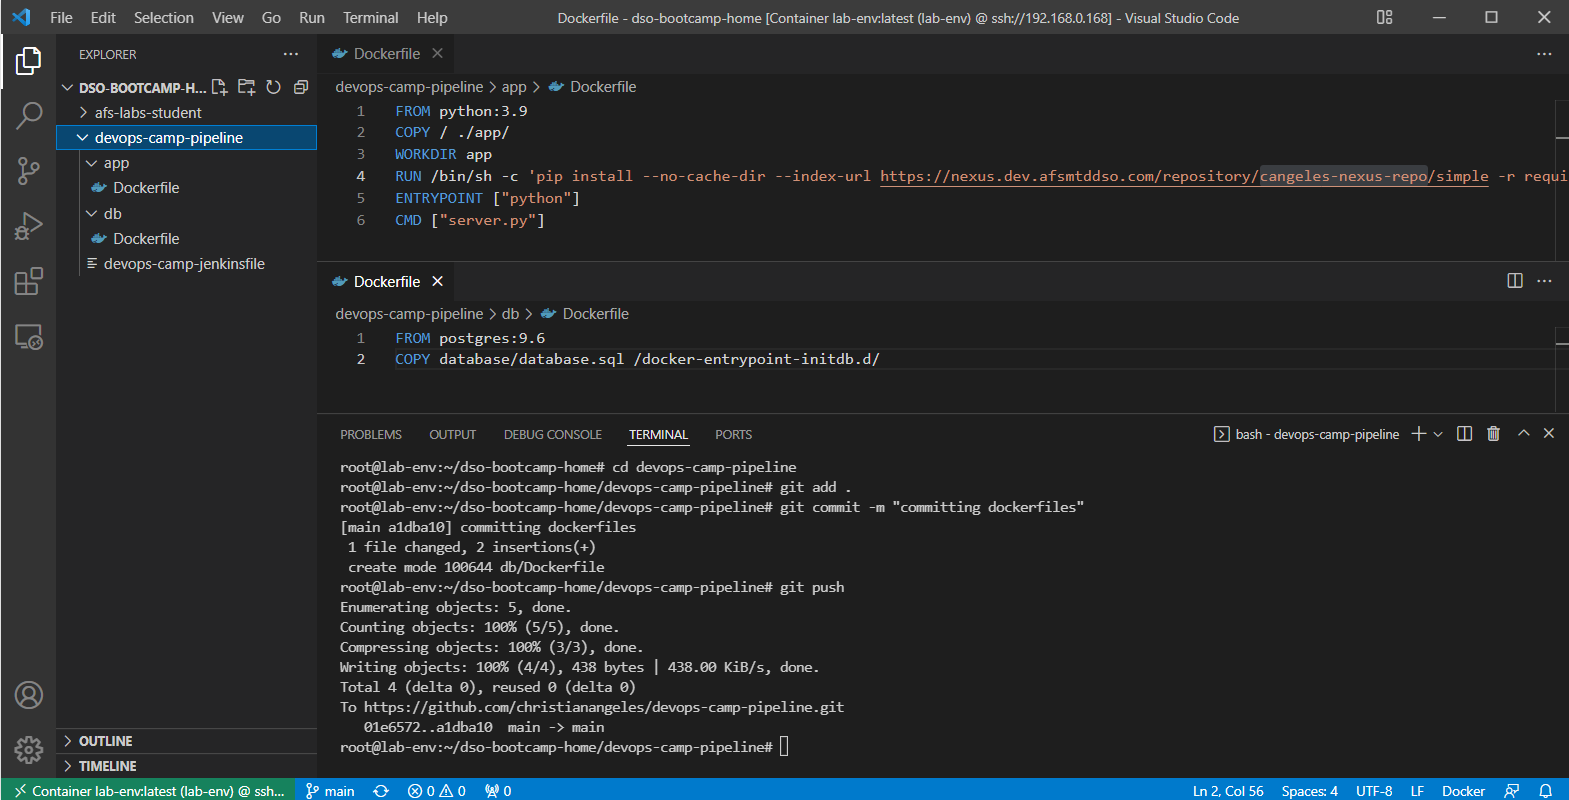
</figure>

## Push Image to Harbor

In this section you'll be integrating Docker and Harbor into your pipeline. The following instructions will have you create credentials for your pipeline in order to authenticate Docker with Harbor. Once you've created the credentials for the pipeline, you'll then configure the pipeline to build the Docker images and push to the Harbor registry.

1.	Create credentials for Harbor in Jenkins by following the instructions below:

  a.	From the Jenkins dashboard, navigate to “Credentials” (1), then in the “Stores scoped to Jenkins” section, select “(global)” (2)

<figure>
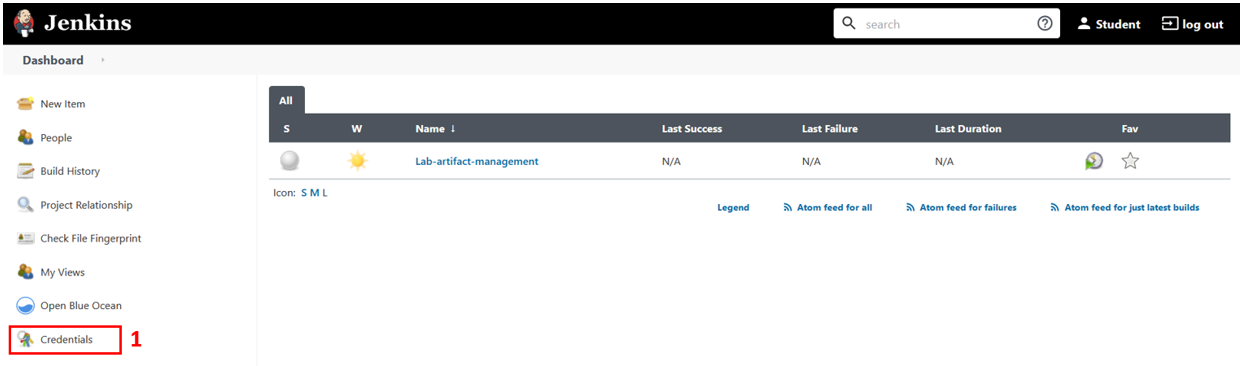
</figure>

<figure>
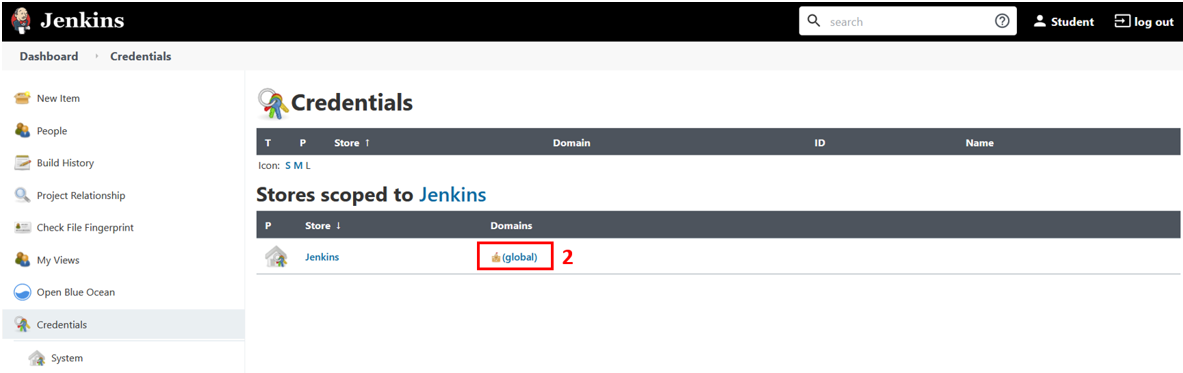
</figure>

<ul>

b. From the “Global Credentials” page, click “Add Credentials” 

</ul>

<figure>
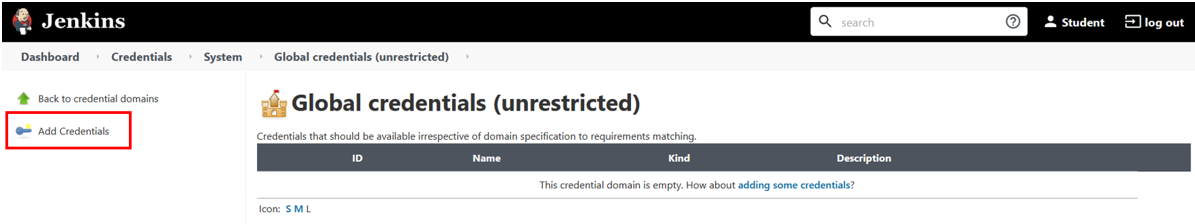
</figure>

<ul>

c.	Then type your Harbor username and password along with the ID name `<FIRST NAME INITIAL + LAST NAME>-harbor-auth`

</ul>

<figure>
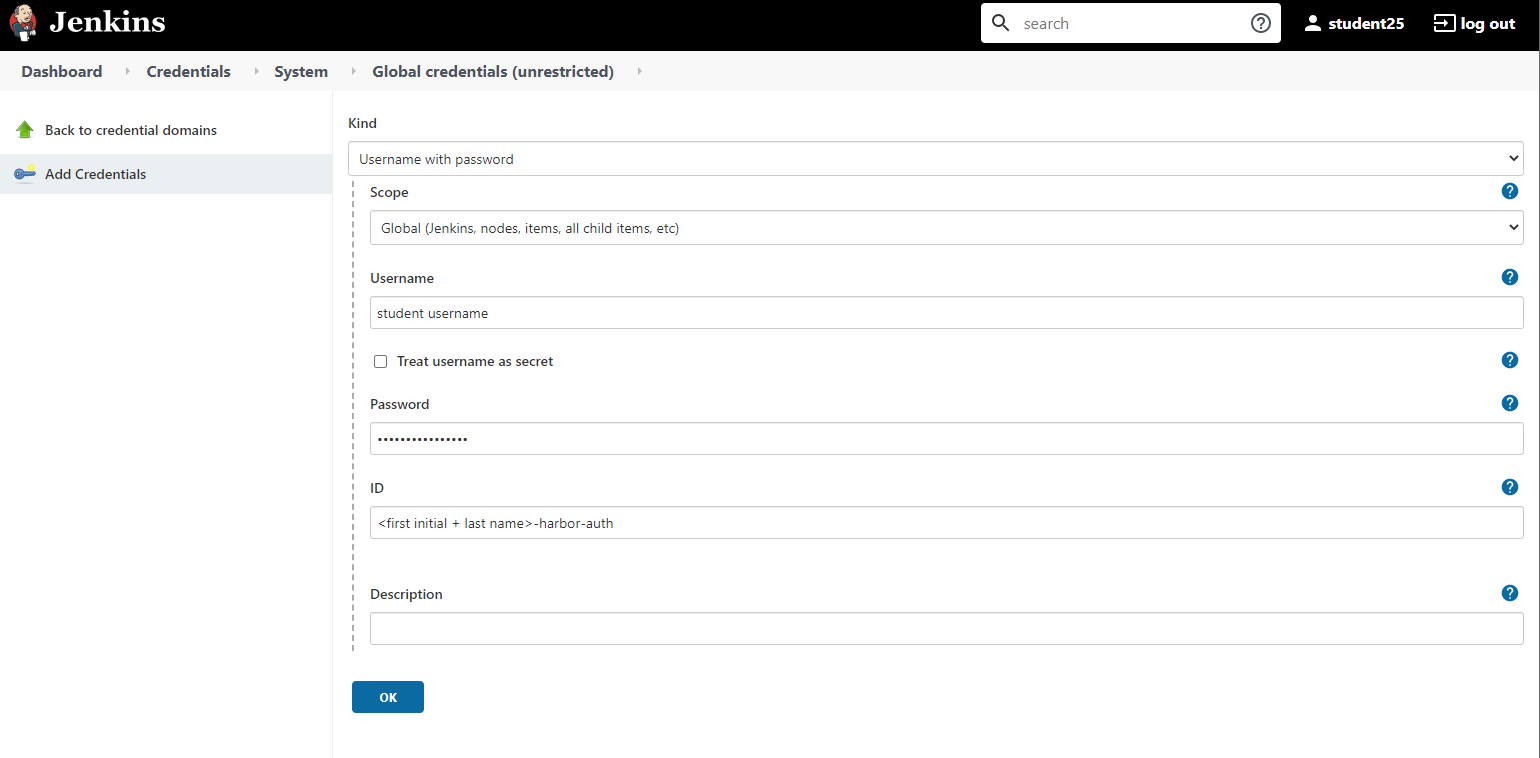
</figure>

2.	Click “OK” to save the credential

3.	In VSCode, in your `devops-camp-pipeline` folder, modify your `devops-camp-jenkinsfile` to build and push the Docker image of your application and database using the instructions below:

  a.	Add environment variables for Harbor to the `pipeline {}` by pasting the below code snippet _after_ the `agent {}` block (and _before_ the `stages {}` block) of your Jenkinsfile:

  >**Tip:** _Replace_ `<YOUR HARBOR PROJECT NAME>` with the name of the Harbor project you created in the containerization lab.


In [ ]:
environment {
        PIPELINE_HASH = sh(script: 'git rev-parse --short HEAD', returnStdout: true).trim()
        HARBOR_REGISTRY = 'harbor.dev.afsmtddso.com'
        HARBOR_PROJECT = '<YOUR HARBOR PROJECT NAME>'
        APP_IMAGE_NAME = 'app'
        DB_IMAGE_NAME = 'db'
    }

<ul>

> **Note:** In Harbor, projects contain repositories which contain artifacts which contain images. In this case, our repositories will be named `$HARBOR_PROJECT/$IMAGE_NAME`, where the image name is either for the application or the database image. Each artifact will contain the multiple commits we make to each image over the course of the project.

b.	Add the following code snippet to the `stage ('Application repository') {}`, _inside_ the `steps {}` block and _after_ the `git clone` line. This will add an environment variable to our pipeline. The `COMMIT_HASH` variable will be used to tag the different versions of our built app/db images.

</ul>

In [ ]:
dir('afs-labs-student') {
                    script {
                        env.COMMIT_HASH = sh(script: 'git rev-parse --short HEAD', returnStdout: true).trim()
                    }
                }

<ul>

> **Note:** `COMMIT_HASH` and `PIPELINE_HASH` will be used to uniquely “tag” the application Docker image.

</ul>

<ul>

c.	Add the following code snippet to the `stage('Application docker build') {}`, _inside_ the `steps {}` block. This will reflect the two actions that are being done: tagging and building the images.

</ul>

In [ ]:
withCredentials([usernameColonPassword(credentialsId: '<YOUR CREDENTIAL ID NAME>', variable: 'HARBOR-AUTH')]) {
                    script {
                        sh 'docker build -t $APP_IMAGE_NAME-$COMMIT_HASH -f ./app/Dockerfile ./afs-labs-student'
                        docker.withRegistry('https://$HARBOR_REGISTRY', '<YOUR CREDENTIAL ID NAME>') {
                            sh 'docker tag $APP_IMAGE_NAME-$COMMIT_HASH $HARBOR_REGISTRY/$HARBOR_PROJECT/$APP_IMAGE_NAME:$COMMIT_HASH-$PIPELINE_HASH'
                            sh 'docker push $HARBOR_REGISTRY/$HARBOR_PROJECT/$APP_IMAGE_NAME:$COMMIT_HASH-$PIPELINE_HASH'
                        }
                    }
                }

<ul>

> **Tip:** _Replace_ both occurrences of `<YOUR CREDENTIAL ID NAME>` with the Harbor credential ID name you created in step 1c (i.e., `<first initial + last name>-harbor-auth`) so that the pipeline can successfully access your Harbor project.

d.	Add the same code snippet above to the `stage('Database docker build') {}`, _inside_ the `steps {}` block. _Replace_ all occurrences of `$APP_IMAGE_NAME` with `$DB_IMAGE_NAME`, and `./app/Dockerfile` with `./db/Dockerfile`

e.	Add the code snippet below to the `stage('Application docker build') {}`, _after_ the `steps {}` block. This will remove the existing Docker images after each build.

</ul>


In [ ]:
post {
                always {
                    echo "Clean local $APP_IMAGE_NAME image"
                    script {
                        try {
                            sh 'docker rmi $APP_IMAGE_NAME-$COMMIT_HASH:latest'
                            sh 'docker rmi $HARBOR_REGISTRY/$HARBOR_PROJECT/$APP_IMAGE_NAME:$COMMIT_HASH-$PIPELINE_HASH'                            
                        } catch (err) {
                            echo err.getMessage()
                        }
                    }
                }
            }

<ul>

f.	Add the same code snippet above to the `stage('Database docker build') {}`, _after_ the `steps {}` block. _Replace_ all occurrences of `$APP_IMAGE_NAME` with `$DB_IMAGE_NAME`

g. Save your changes to the `devops-camp-jenkinsfile`

h.	In your terminal, make sure you're in the correct directory before committing your updated Jenkinsfile and pushing the commit to your remote repository to trigger a build of your updated pipeline. Your image should be uploaded to Harbor after the pipeline finishes 

</ul>

<figure>
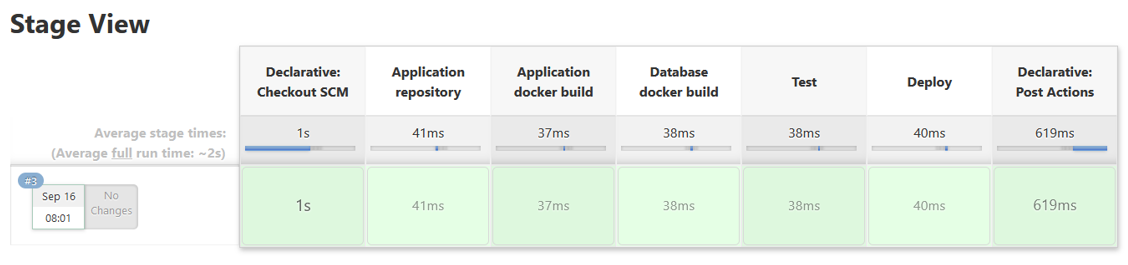
</figure>

## You're done if...

If your Jenkins pipeline builds correctly - i.e., all the stages are green - then you're done!



# Appendix
For your reference, a sample completed `devops-camp-jenkinsfile` can be found below.  Please note that this is intended as a sample but will not work as is, since it is based on another user’s credentials and configuration: https://github.com/khaledAFS/sample-files/blob/main/devops-camp-jenkinsfile-post-artifact-mgmt-lab 
